# Preprocessing

## Loading data / packages

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import bigfish.detection as detection

# RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-10-09 - SeqFISH_Run10 - HeLa-Puro_POLR2" 
RUN_PATH = "/mnt/ssd/SSD_floricslimani/Fish_seq/Davide/2024-09-03 - SeqFISH_Run8 - HeLa_POLR2"

OUTPUT_PATH = RUN_PATH + "/analysis/density/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [33]:
Acquisition = pd.read_feather(RUN_PATH + "/result_tables/Acquisition.feather")
Detection = pd.read_feather(RUN_PATH + "/result_tables/Detection.feather")
Spots = pd.read_feather(RUN_PATH + "/result_tables/Spots.feather")
Drift = pd.read_feather(RUN_PATH + "/result_tables/Drift.feather")
Gene_map = pd.read_feather(RUN_PATH + "/result_tables/Gene_map.feather")

## Spots filtering

### Washout

In [34]:
check_len = len(Spots)
Spots = Spots.loc[~Spots['is_washout']]
print(f"{check_len - len(Spots)} spots filtered.")

1344 spots filtered.


### Out of segmentation

In [35]:
check_len = len(Spots)
Spots = Spots.loc[Spots['cell_label'] != 0]
print(f"{check_len - len(Spots)} spots filtered.")

37116 spots filtered.


## Data merge

In [36]:
check_len = len(Detection)
Detection = pd.merge(
    Detection,
    Acquisition.loc[:,['acquisition_id', 'cycle', 'location']],
    on= 'acquisition_id',
    suffixes=('','_acquisition')
)
assert len(Detection) == check_len

Detection = pd.merge(
    Detection,
    Gene_map.loc[:,['cycle','color_id','target']],
    on= ['cycle','color_id']
)
assert len(Detection) == check_len

check_len = len(Spots)
Spots = pd.merge(
    Spots,
    Detection.loc[:,['detection_id', 'acquisition_id', 'target', 'location']],
    on= 'detection_id'
)
assert len(Spots) == check_len


# General clustering

Here we perform DBSCAN algorithm by pulling together spots from all channels so as to identify site of interaction between channels

- can we produce a 3D heatmap showing density of spots per pixel ?
- add new multichannel clusters to viewer
- additional graph analysis

*Note : functional version of this code available in **density.py***

## Post-processing

### Parameters

In [37]:
VOXEL_SIZE = tuple(Detection['voxel_size'].iat[0])
VOXEL_SIZE = [int(i) for i in VOXEL_SIZE]

MIN_NB_CLUSTER = 3 # Number for multiRNA cluster analysis

CLUSTER_RADIUS = 400 # Colocalization analysis
# CLUSTER_RADIUS = Detection['cluster_size'].iat[0] # regular clustering

### Pooling data

In [38]:
spots_coordinates_per_fov = Spots.groupby(['location']).agg({
    'z' : list,
    'y' : list,
    'x' : list,
    })
spots_coordinates_per_fov

z  \
location                                                         
Location-01  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-02  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-03  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-04  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-05  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-06  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-07  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-08  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-09  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   
Location-10  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...   

                                                             y  \
location                                                         
Location-01  [0, 77, 141, 144, 265, 282, 284, 291, 305, 349...   
Location-02  [4, 26, 35, 40, 46, 53, 54, 56, 74, 105, 118, ...   
Location-03  [8, 20, 32, 45, 64, 79, 84, 84, 86, 89, 96, 11...   
Location-04  [14, 21, 28, 29, 33, 33, 40, 54, 55, 57, 58, 5...   
Location-05  [0, 10, 16, 76, 77, 96, 97, 111, 112, 128, 134...   
Location-06  [10, 28, 33, 127, 170, 174, 244, 248, 253, 255...   
Location-07  [201, 202, 241, 250, 250, 268, 275, 313, 316, ...   
Location-08  [3, 128, 137, 143, 158, 160, 178, 211, 215, 22...   
Location-09  [50, 56, 60, 60, 104, 117, 119, 119, 122, 127,...   
Location-10  [48, 115, 153, 320, 329, 478, 484, 487, 491, 4...   

                                                             x  
location                                                        
Location-01  [597, 389, 993, 1107, 673, 617, 575, 208, 648,...  
Location-02  [1266, 531, 1282, 1559, 1236, 1234, 693, 556, ...  
Location-03  [699, 1219, 640, 642, 728, 942, 962, 1309, 721...  
Location-04  [266, 1104, 350, 332, 305, 1082, 279, 1044, 58...  
Location-05  [1043, 1018, 1047, 1004, 1146, 1094, 1106, 163...  
Location-06  [92, 100, 77, 837, 1146, 1200, 254, 62, 814, 1...  
Location-07  [1101, 1579, 373, 400, 1099, 1128, 1180, 728, ...  
Location-08  [25, 716, 668, 693, 598, 520, 668, 609, 625, 5...  
Location-09  [1755, 1711, 1757, 1762, 1900, 1861, 1840, 187...  
Location-10  [939, 1379, 210, 981, 984, 965, 666, 960, 904,...

### DBSCAN

In [39]:
Spots_clustered = pd.DataFrame(columns=['cluster_id','z','y','x', 'location'])
for location in spots_coordinates_per_fov.index : 
    data_selec = spots_coordinates_per_fov.loc[location]

    spots = np.array(
        list(zip(data_selec['z'],data_selec['y'],data_selec['x'],)),
        dtype=int)

    clustered_spot, clusters = detection.detect_clusters(
        spots,
        VOXEL_SIZE,
        CLUSTER_RADIUS,
        MIN_NB_CLUSTER,
    )

    z,y,x, cluster_id = zip(*clustered_spot)
    cluster_z, cluster_y, cluster_x, spot_number, cluster_index = zip(*clusters)

    new_Spots_clustered = pd.DataFrame({
            'cluster_id' : cluster_id,
            'z' : z,
            'y' : y,
            'x' : x,
            'location' : location,
        })
    
    new_Clusters = pd.DataFrame({
        'cluster_id' : cluster_index,
        'cluster_centroid_z' : cluster_z, 
        'cluster_centroid_y' : cluster_y, 
        'cluster_centroid_x' : cluster_x, 
    })

    check_len = len(new_Spots_clustered)
    new_Spots_clustered = pd.merge(
        new_Spots_clustered,
        new_Clusters,
        on='cluster_id',
        how='left',
        validate='m:1'
    )
    assert len(new_Spots_clustered) == check_len , "check for duplication"

    Spots_clustered = pd.concat([
        Spots_clustered,
        new_Spots_clustered,
    ], axis= 0)

Spots_clustered

cluster_id   z     y     x     location  cluster_centroid_z  \
0             -1   5     0   597  Location-01                 NaN   
1             -1   5    77   389  Location-01                 NaN   
2             -1   5   141   993  Location-01                 NaN   
3             -1   5   144  1107  Location-01                 NaN   
4            849   5   265   673  Location-01                 5.0   
...          ...  ..   ...   ...          ...                 ...   
31871         -1  47   867  1705  Location-10                 NaN   
31872         -1  47  1463   583  Location-10                 NaN   
31873         -1  47  1656   934  Location-10                 NaN   
31874         -1  48  1786  1581  Location-10                 NaN   
31875        992  48  1299   621  Location-10                47.0   

       cluster_centroid_y  cluster_centroid_x  
0                     NaN                 NaN  
1                     NaN                 NaN  
2                     NaN                 NaN  
3                     NaN                 NaN  
4                   262.0               673.0  
...                   ...                 ...  
31871                 NaN                 NaN  
31872                 NaN                 NaN  
31873                 NaN                 NaN  
31874                 NaN                 NaN  
31875              1299.0               621.0  

[300534 rows x 8 columns]

### Duplicated values after clustering

This dataframe is expected to contain duplicated values for spots with perfect colocalization. What is important for downstream analysis is that they have the same cluster_id. Next step is to retrieve this cluster id to the main Spots table, to avoid duplication during merge on coordinates, we remove duplicated rows.

In [40]:
Spots_clustered[Spots_clustered.duplicated()]

cluster_id   z     y     x     location  cluster_centroid_z  \
1537          -1   6   380  1212  Location-01                 NaN   
1554          55   6   867   383  Location-01                 7.0   
1568          -1   5  1040   538  Location-01                 NaN   
1584          60   5  1115   779  Location-01                 5.0   
1588          -1   7  1114   747  Location-01                 NaN   
...          ...  ..   ...   ...          ...                 ...   
31364         -1  17  1621   557  Location-10                 NaN   
31425         -1  20   600    63  Location-10                 NaN   
31532        983  25   844   501  Location-10                24.0   
31811         -1  43   482   251  Location-10                 NaN   
31837         -1  43   426  1227  Location-10                 NaN   

       cluster_centroid_y  cluster_centroid_x  
1537                  NaN                 NaN  
1554                867.0               383.0  
1568                  NaN                 NaN  
1584               1115.0               780.0  
1588                  NaN                 NaN  
...                   ...                 ...  
31364                 NaN                 NaN  
31425                 NaN                 NaN  
31532               843.0               501.0  
31811                 NaN                 NaN  
31837                 NaN                 NaN  

[4546 rows x 8 columns]

In [41]:
prev_len = len(Spots_clustered)
Spots_clustered = Spots_clustered.drop_duplicates()
print("{0} duplicates dropped.".format(prev_len - len(Spots_clustered)))

4546 duplicates dropped.


### Merging data into main Spots frame

In [42]:
check_len = len(Spots) #No filter/duplication expected.

Spots_clustered = Spots_clustered.rename(columns={'cluster_id' : 'general_cluster_id'})
print("clustered :",len(Spots_clustered))

Spots = pd.merge(
    Spots,
    Spots_clustered,
    on=['location','z','y','x'],
    validate= 'm:1'
)

assert len(Spots) == check_len
Spots

clustered : 295988


spot_id  cluster_id  drifted_z  drifted_y  drifted_x  intensity  \
0             0         NaN          5          0        597       5927   
1             1         NaN          5         77        389       6095   
2             2         NaN          5        141        993       6923   
3             3         NaN          5        144       1107       6960   
4             4         NaN          5        265        673       7111   
...         ...         ...        ...        ...        ...        ...   
300529   338986         NaN         47        867       1705       4061   
300530   338988         NaN         47       1463        583       4628   
300531   338990         NaN         47       1656        934       4044   
300532   338991         NaN         48       1786       1581       4024   
300533   338993         6.0         48       1299        621       4413   

       population  detection_id  acquisition_id_x  drift_z  ...  \
0            free             1                 0        0  ...   
1            free             1                 0        0  ...   
2            free             1                 0        0  ...   
3            free             1                 0        0  ...   
4            free             1                 0        0  ...   
...           ...           ...               ...      ...  ...   
300529       free           208               189        0  ...   
300530       free           208               189        0  ...   
300531       free           208               189        0  ...   
300532       free           208               189        0  ...   
300533  clustered           208               189        0  ...   

             coordinates  in_nucleus  cell_label  acquisition_id_y  target  \
0            [5, 0, 597]        True         2.0                 0  POLR2A   
1           [5, 77, 389]       False         1.0                 0  POLR2A   
2          [5, 141, 993]       False         5.0                 0  POLR2A   
3         [5, 144, 1107]        True         5.0                 0  POLR2A   
4          [5, 265, 673]        True         6.0                 0  POLR2A   
...                  ...         ...         ...               ...     ...   
300529   [47, 867, 1705]       False        19.0               189  POLR2L   
300530   [47, 1463, 583]        True        27.0               189  POLR2L   
300531   [47, 1656, 934]       False        37.0               189  POLR2L   
300532  [48, 1786, 1581]       False        39.0               189  POLR2L   
300533   [48, 1299, 621]        True        38.0               189  POLR2L   

           location general_cluster_id cluster_centroid_z  cluster_centroid_y  \
0       Location-01                 -1                NaN                 NaN   
1       Location-01                 -1                NaN                 NaN   
2       Location-01                 -1                NaN                 NaN   
3       Location-01                 -1                NaN                 NaN   
4       Location-01                849                5.0               262.0   
...             ...                ...                ...                 ...   
300529  Location-10                 -1                NaN                 NaN   
300530  Location-10                 -1                NaN                 NaN   
300531  Location-10                 -1                NaN                 NaN   
300532  Location-10                 -1                NaN                 NaN   
300533  Location-10                992               47.0              1299.0   

       cluster_centroid_x  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                   673.0  
...                   ...  
300529                NaN  
300530                NaN  
300531                NaN  
300532                NaN  
300533              621.0  

[300534 rows x 31 columns]

# Analysis

### Data grouping

In [43]:
Clustered_spots = Spots.loc[Spots['general_cluster_id'] != -1]

multichannel_clusters = Clustered_spots.groupby(['location', 'general_cluster_id']).aggregate({
    'spot_id' : 'count',
    'target' : ['nunique','unique'],
    'cluster_centroid_z' : 'first',
    'cluster_centroid_y' : 'first',
    'cluster_centroid_x' : 'first',
})

multichannel_clusters.columns = pd.Index(['spot number', 'rna number', 'rna list', 'z', 'y', 'x'])

multichannel_clusters.to_excel(OUTPUT_PATH + "Multichannel_cluster.xlsx")
multichannel_clusters

spot number  rna number  \
location    general_cluster_id                            
Location-01 0                             6           4   
            1                             3           3   
            2                             6           5   
            3                             3           3   
            4                             3           2   
...                                     ...         ...   
Location-10 996                           5           1   
            997                           3           1   
            998                           3           2   
            999                           3           1   
            1000                          3           2   

                                                                rna list  \
location    general_cluster_id                                             
Location-01 0                           [POLR2A, POLR2E, POLR2F, POLR2H]   
            1                                   [POLR2A, POLR2H, POLR2J]   
            2                   [POLR2A, POLR2B, POLR2J, POLR2K, POLR2L]   
            3                                   [POLR2A, POLR2B, POLR2F]   
            4                                           [POLR2A, POLR2E]   
...                                                                  ...   
Location-10 996                                                 [POLR2L]   
            997                                                 [POLR2L]   
            998                                         [POLR2C, POLR2L]   
            999                                                 [POLR2L]   
            1000                                        [POLR2A, POLR2L]   

                                   z       y       x  
location    general_cluster_id                        
Location-01 0                    5.0   351.0   964.0  
            1                    5.0   486.0   222.0  
            2                    5.0   893.0   413.0  
            3                    5.0   912.0   765.0  
            4                    5.0   917.0   797.0  
...                              ...     ...     ...  
Location-10 996                 17.0    97.0  1859.0  
            997                 26.0  1497.0    30.0  
            998                 41.0   772.0  1226.0  
            999                 39.0   789.0   705.0  
            1000                40.0   490.0   425.0  

[10529 rows x 6 columns]

In [44]:
updated_spots = pd.merge(
    Spots,
    multichannel_clusters.loc[:,['rna number']],
    on=['location','general_cluster_id'],
)
assert len(Spots[Spots['general_cluster_id'] != -1]) == len(updated_spots), "Non unique (location,general_cluster_id)"
updated_spots

spot_id  cluster_id  drifted_z  drifted_y  drifted_x  intensity  \
0            4         NaN          5        265        673       7111   
1        21898         NaN          5        259        673       6813   
2        23589         NaN          5        262        673       8489   
3            8         NaN          5        305        648       7325   
4        16223         NaN          5        301        643       8909   
...        ...         ...        ...        ...        ...        ...   
41663   338565        10.0         26       1496         30       6371   
41664   338566        10.0         26       1498         30       6232   
41665   338863         NaN         39        790        705       4748   
41666   338864         NaN         39        789        706       4552   
41667   338924         NaN         41        790        705       4450   

      population  detection_id  acquisition_id_x  drift_z  ...  in_nucleus  \
0           free             1                 0        0  ...        True   
1           free            13               120        0  ...        True   
2           free            15               140        0  ...        True   
3           free             1                 0        0  ...        True   
4           free             9                80        0  ...        True   
...          ...           ...               ...      ...  ...         ...   
41663  clustered           208               189        0  ...        True   
41664  clustered           208               189        0  ...        True   
41665       free           208               189        0  ...       False   
41666       free           208               189        0  ...       False   
41667       free           208               189        0  ...       False   

       cell_label  acquisition_id_y  target     location general_cluster_id  \
0             6.0                 0  POLR2A  Location-01                849   
1             6.0               120  POLR2I  Location-01                849   
2             6.0               140  POLR2J  Location-01                849   
3             6.0                 0  POLR2A  Location-01                791   
4             6.0                80  POLR2F  Location-01                791   
...           ...               ...     ...          ...                ...   
41663        40.0               189  POLR2L  Location-10                997   
41664        40.0               189  POLR2L  Location-10                997   
41665        14.0               189  POLR2L  Location-10                999   
41666        14.0               189  POLR2L  Location-10                999   
41667        14.0               189  POLR2L  Location-10                999   

      cluster_centroid_z cluster_centroid_y  cluster_centroid_x rna number  
0                    5.0              262.0               673.0          3  
1                    5.0              262.0               673.0          3  
2                    5.0              262.0               673.0          3  
3                    5.0              304.0               645.0          4  
4                    5.0              304.0               645.0          4  
...                  ...                ...                 ...        ...  
41663               26.0             1497.0                30.0          1  
41664               26.0             1497.0                30.0          1  
41665               39.0              789.0               705.0          1  
41666               39.0              789.0               705.0          1  
41667               39.0              789.0               705.0          1  

[41668 rows x 32 columns]

## General Plots

### Number of cluster with n number of RNA

In [45]:
cluster_plurality_number = multichannel_clusters['rna number'].unique()
cluster_plurality_number = list(cluster_plurality_number)
cluster_plurality_number.sort()
print(f"{len(cluster_plurality_number)} different size of cluster found.")
cluster_plurality_number

10 different size of cluster found.


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

### Total rna number VS diversity of cluster

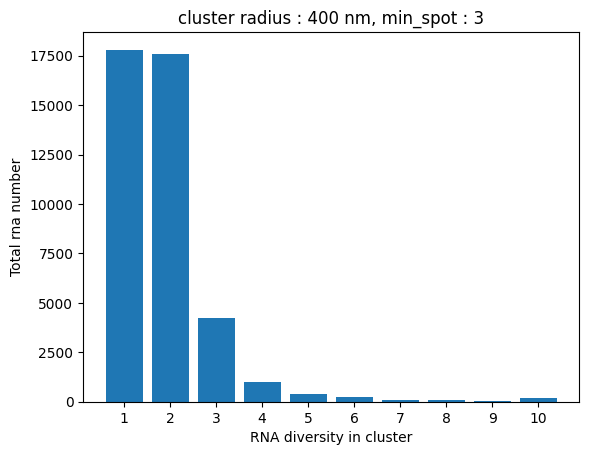

In [46]:
fig = plt.figure()
ax = fig.gca()

data = multichannel_clusters.groupby("rna number")['spot number'].sum()
ax.bar(data.index, data, align='center')
ax.set_xticks(data.index)
ax.set_ylabel("Total rna number")
ax.set_xlabel("RNA diversity in cluster")
ax.set_title(f"cluster radius : {CLUSTER_RADIUS} nm, min_spot : {MIN_NB_CLUSTER}")

plt.show()

### Total rna number per RNA per diversity

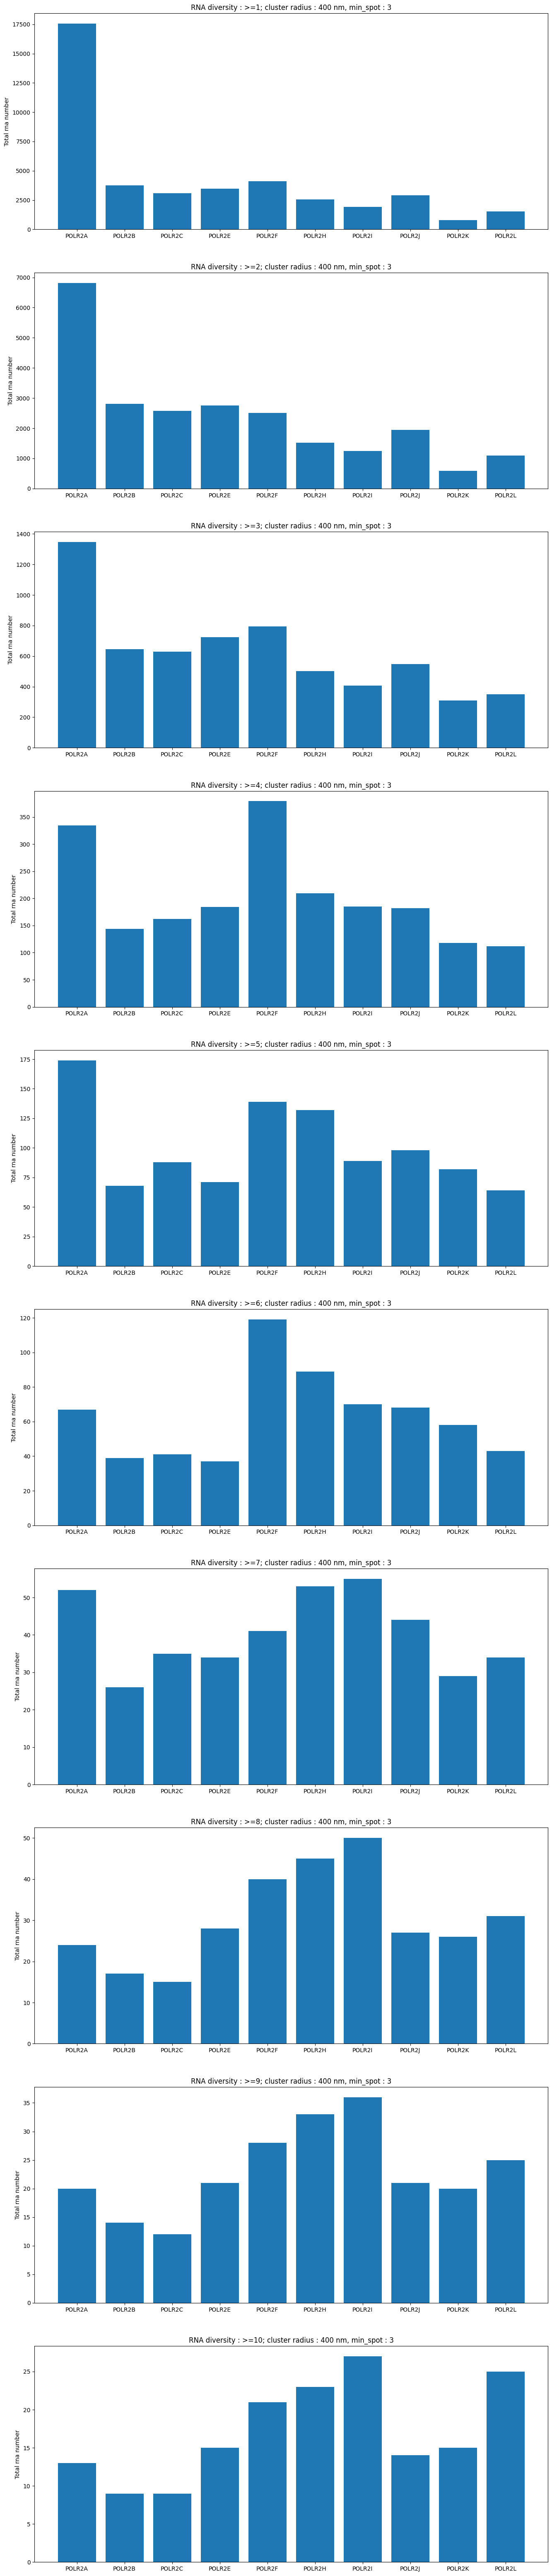

In [47]:
fig, axes = plt.subplots(nrows= len(cluster_plurality_number), ncols=1, figsize = (16,8*len(cluster_plurality_number)))

for ax, dimension in zip(axes, cluster_plurality_number) :
    ax:plt.Axes
    ax.set_title(f"RNA diversity : >={dimension}; cluster radius : {CLUSTER_RADIUS} nm, min_spot : {MIN_NB_CLUSTER}")

    data = updated_spots.loc[updated_spots['rna number'] >= dimension]
    data = data.groupby('target')['spot_id'].count()


    X = list(range(len(data)))
    ax.bar(X, data,align='center')
    ax.set_xticks(X, labels=data.index)
    ax.set_ylabel("Total rna number")

plt.show()

## Affinity & presence


### Cluster unity table

Here we build a DataFrame showing for each cluster the number of single molecules from each RNA in the dataset

In [48]:
MIN_DIVERSITY = 3

In [49]:
#Filtering spots from cluster with less than MIN_DIVERSITY different rnas.
data = updated_spots.loc[updated_spots['rna number'] >= MIN_DIVERSITY]

#Init empty table : each line is a cluster and each RNA of data set are reprensented in columns with their single molecule number in this cluster; init to 0.
cluster_list = pd.Series(zip(data['location'], data['general_cluster_id'])).unique()
cluster_list = pd.MultiIndex.from_tuples(cluster_list)
RNA_list = data['target'].unique()
cluster_unity_counts = pd.DataFrame(index=cluster_list, columns=RNA_list, dtype=int, data=0).sort_index()

#Creating table with all counts of single molecule per cluster per rna
agg_table = data.groupby(['location', 'general_cluster_id','target'])['spot_id'].count()
for location, cluster_id, rna in agg_table.index :
    value = agg_table.at[(location,cluster_id,rna)]
    cluster_unity_counts.loc[(location,cluster_id), rna] += value

#Assign values from groupby to cluster table
total = cluster_unity_counts.sum(axis=1).astype(int)
cluster_unity_counts

POLR2A  POLR2I  POLR2J  POLR2F  POLR2H  POLR2E  POLR2B  \
Location-01 0         1       0       0       2       1       2       0   
            1         1       0       1       0       1       0       0   
            2         1       0       1       0       0       0       2   
            3         1       0       0       1       0       0       1   
            5         1       0       0       0       1       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
Location-10 857       0       0       3       0       3       0       0   
            897       0       1       0       1       0       0       0   
            899       0       2       0       1       1       0       0   
            909       1       1       1       0       0       0       0   
            973       0       0       0       1       1       0       0   

                 POLR2K  POLR2L  POLR2C  
Location-01 0         0       0       0  
            1         0       0       0  
            2         1       1       0  
            3         0       0       0  
            5         2       0       0  
...                 ...     ...     ...  
Location-10 857       0       1       0  
            897       2       0       0  
            899       0       0       0  
            909       0       0       0  
            973       1       0       0  

[1164 rows x 10 columns]

### Affinity & Presence tables

In [50]:
presence_dict = {}
affinity_dict = {}

for rna in RNA_list :
    rna_index = cluster_unity_counts.loc[cluster_unity_counts[rna] > 0].index
    data = cluster_unity_counts.loc[rna_index]

    affinity_df = data.apply(lambda x : x/total.loc[rna_index])
    affinity_df_total = affinity_df.sum(axis=1).round(10)
    assert (affinity_df_total == 1).all(), affinity_df[affinity_df_total != 1]
    affinity_dict[rna] = affinity_df

    presence_df = data.apply(lambda x : x.astype(bool))
    presence_dict[rna] = presence_df



presence_df


POLR2A  POLR2I  POLR2J  POLR2F  POLR2H  POLR2E  POLR2B  \
Location-01 13     True   False   False   False   False    True   False   
            24     True   False   False   False   False    True   False   
            60     True    True   False   False   False   False    True   
            65     True   False   False   False   False    True   False   
            72     True   False   False   False   False   False   False   
...                 ...     ...     ...     ...     ...     ...     ...   
Location-10 685   False    True   False   False   False    True   False   
            704   False   False   False    True   False   False   False   
            705   False   False   False    True    True   False   False   
            768   False   False    True   False   False    True   False   
            815   False   False   False    True   False   False   False   

                 POLR2K  POLR2L  POLR2C  
Location-01 13    False   False    True  
            24    False   False    True  
            60     True   False    True  
            65    False   False    True  
            72     True   False    True  
...                 ...     ...     ...  
Location-10 685   False   False    True  
            704   False    True    True  
            705   False   False    True  
            768   False   False    True  
            815   False    True    True  

[415 rows x 10 columns]

### Presence plots

Shows for each rna when it was found in a cluster of often other RNA were found in that cluster

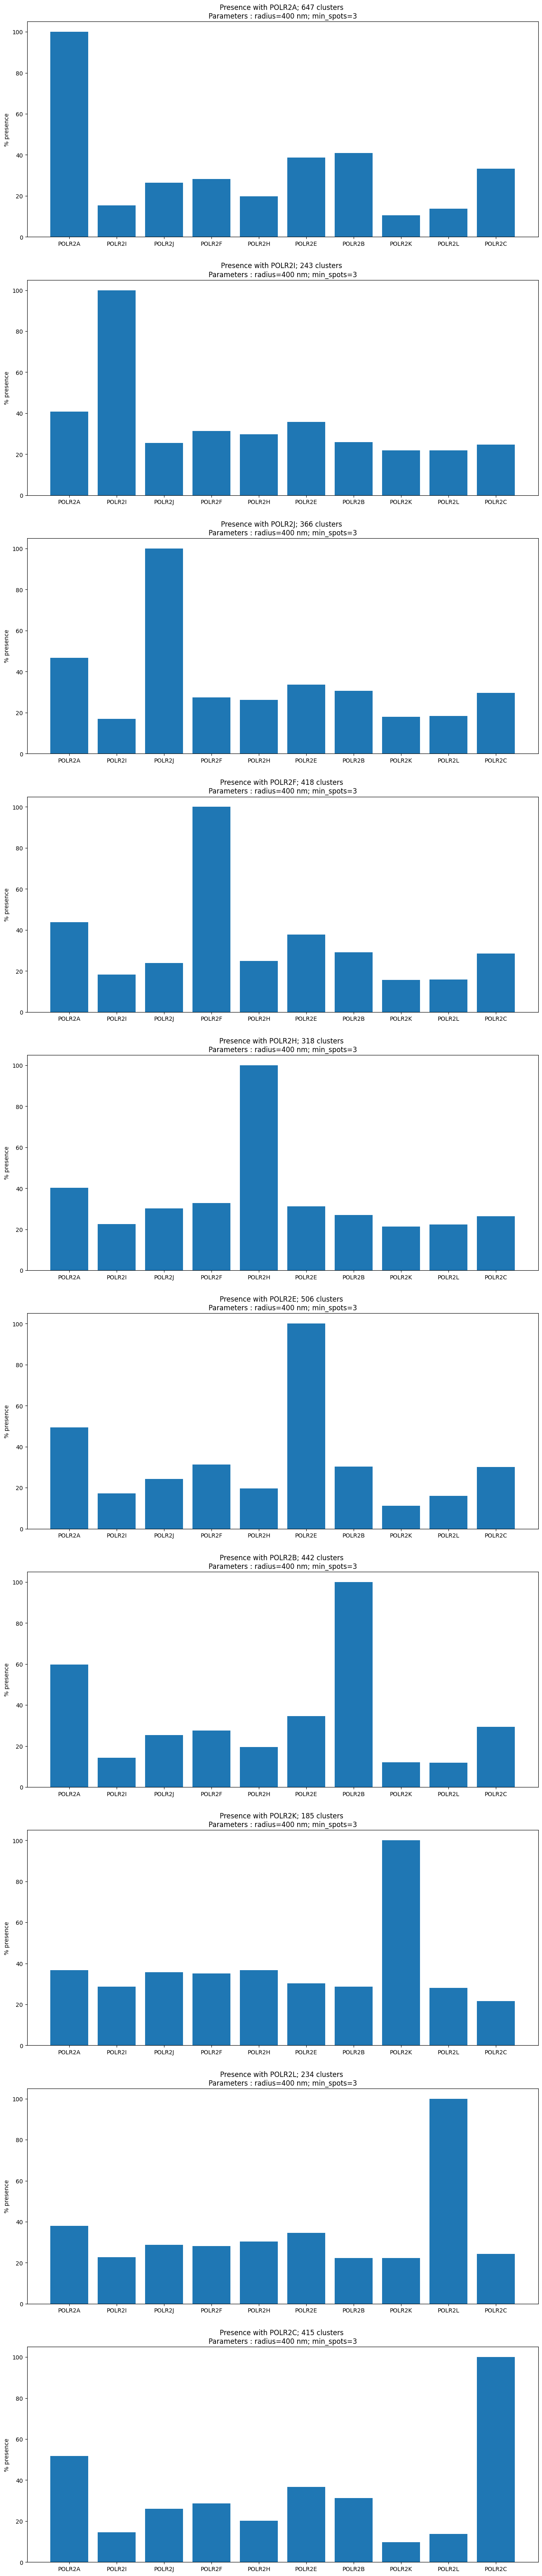

In [51]:
fig, axes = plt.subplots(nrows=len(RNA_list), ncols=1, figsize= (16,8*len(RNA_list)))

for ax, rna in zip(axes, RNA_list) :
    ax : plt.Axes

    data : pd.DataFrame = presence_dict[rna]
    cluster_number = len(data)
    data = data.sum(axis=0) / cluster_number * 100

    ax.set_title(f"Presence with {rna}; {cluster_number} clusters \nParameters : radius={CLUSTER_RADIUS} nm; min_spots={MIN_NB_CLUSTER}")
    ax.bar(data.index, data)
    ax.set_ylabel("% presence")

plt.show()

### Affinity plots

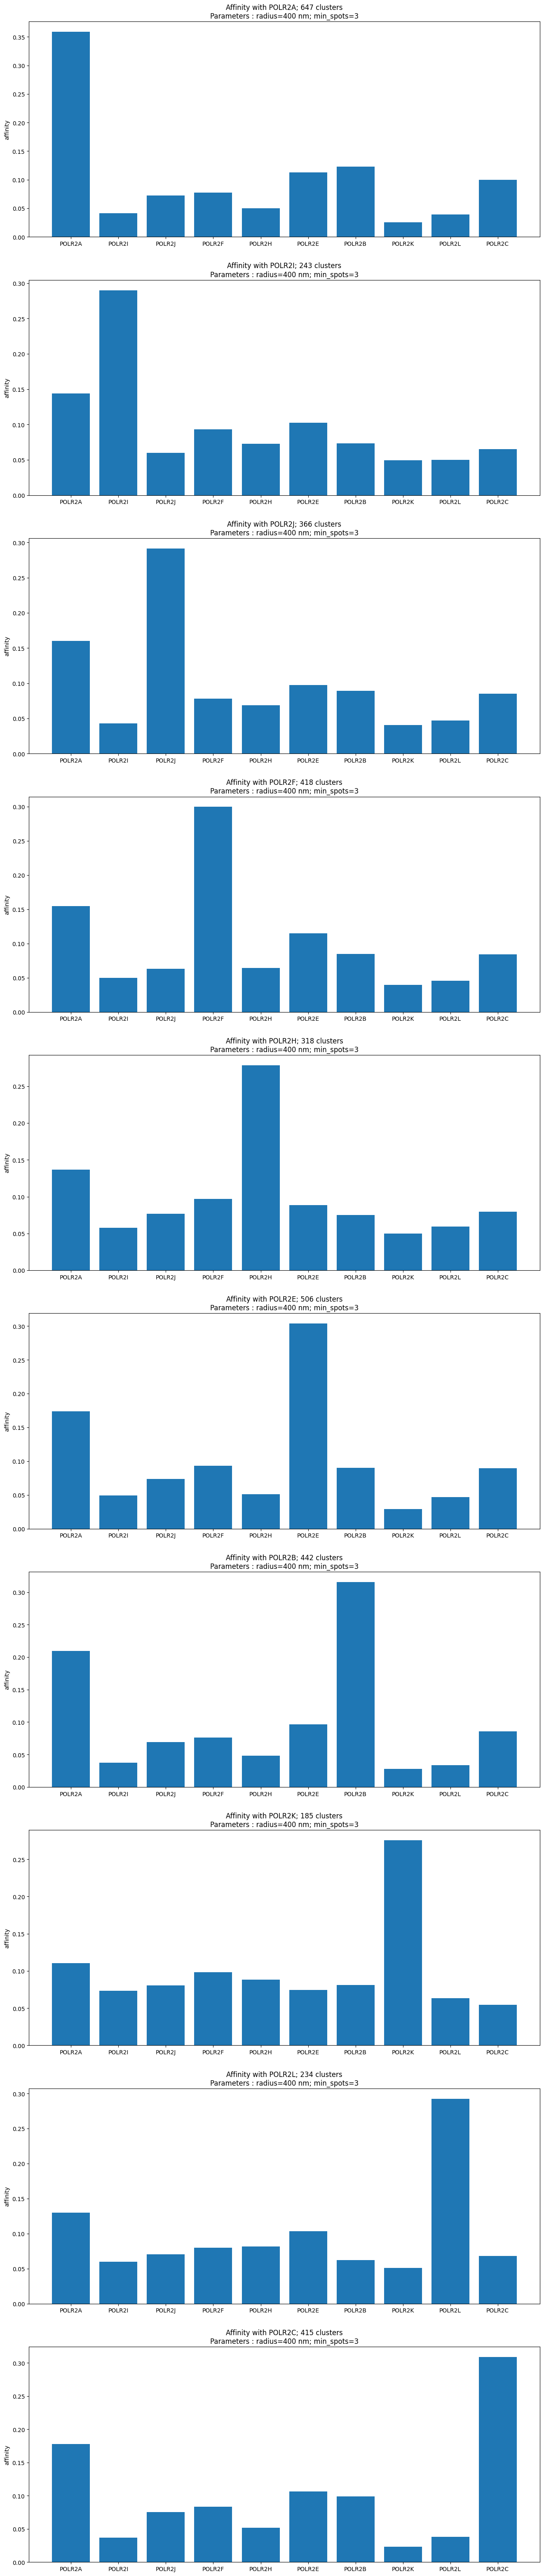

In [52]:
fig, axes = plt.subplots(nrows=len(RNA_list), ncols=1, figsize= (16,8*len(RNA_list)))

for ax, rna in zip(axes, RNA_list) :
    ax : plt.Axes

    data : pd.DataFrame = affinity_dict[rna]
    cluster_number = len(data)
    data = data.mean(axis=0)
    data_std = data.std(axis=0)

    ax.set_title(f"Affinity with {rna}; {cluster_number} clusters\nParameters : radius={CLUSTER_RADIUS} nm; min_spots={MIN_NB_CLUSTER}")
    ax.bar(data.index, data)
    ax.set_ylabel("affinity")

plt.show()

## Combination Tree

In [53]:
import networkx as nx
import itertools

RNA_list = list(presence_df.columns)

presence_df

POLR2A  POLR2I  POLR2J  POLR2F  POLR2H  POLR2E  POLR2B  \
Location-01 13     True   False   False   False   False    True   False   
            24     True   False   False   False   False    True   False   
            60     True    True   False   False   False   False    True   
            65     True   False   False   False   False    True   False   
            72     True   False   False   False   False   False   False   
...                 ...     ...     ...     ...     ...     ...     ...   
Location-10 685   False    True   False   False   False    True   False   
            704   False   False   False    True   False   False   False   
            705   False   False   False    True    True   False   False   
            768   False   False    True   False   False    True   False   
            815   False   False   False    True   False   False   False   

                 POLR2K  POLR2L  POLR2C  
Location-01 13    False   False    True  
            24    False   False    True  
            60     True   False    True  
            65    False   False    True  
            72     True   False    True  
...                 ...     ...     ...  
Location-10 685   False   False    True  
            704   False    True    True  
            705   False   False    True  
            768   False   False    True  
            815   False    True    True  

[415 rows x 10 columns]

In [54]:
r = 3
combinations = list(itertools.combinations(RNA_list, r=r))
for combi in combinations :
    print(combi)
    print(len(presence_df[presence_df.loc[:,combi].all(axis=1)]))
    

('POLR2A', 'POLR2I', 'POLR2J')
6
('POLR2A', 'POLR2I', 'POLR2F')
7
('POLR2A', 'POLR2I', 'POLR2H')
7
('POLR2A', 'POLR2I', 'POLR2E')
8
('POLR2A', 'POLR2I', 'POLR2B')
7
('POLR2A', 'POLR2I', 'POLR2K')
5
('POLR2A', 'POLR2I', 'POLR2L')
5
('POLR2A', 'POLR2I', 'POLR2C')
24
('POLR2A', 'POLR2J', 'POLR2F')
4
('POLR2A', 'POLR2J', 'POLR2H')
9
('POLR2A', 'POLR2J', 'POLR2E')
4
('POLR2A', 'POLR2J', 'POLR2B')
11
('POLR2A', 'POLR2J', 'POLR2K')
7
('POLR2A', 'POLR2J', 'POLR2L')
6
('POLR2A', 'POLR2J', 'POLR2C')
43
('POLR2A', 'POLR2F', 'POLR2H')
7
('POLR2A', 'POLR2F', 'POLR2E')
7
('POLR2A', 'POLR2F', 'POLR2B')
8
('POLR2A', 'POLR2F', 'POLR2K')
4
('POLR2A', 'POLR2F', 'POLR2L')
4
('POLR2A', 'POLR2F', 'POLR2C')
41
('POLR2A', 'POLR2H', 'POLR2E')
10
('POLR2A', 'POLR2H', 'POLR2B')
9
('POLR2A', 'POLR2H', 'POLR2K')
6
('POLR2A', 'POLR2H', 'POLR2L')
6
('POLR2A', 'POLR2H', 'POLR2C')
34
('POLR2A', 'POLR2E', 'POLR2B')
12
('POLR2A', 'POLR2E', 'POLR2K')
6
('POLR2A', 'POLR2E', 'POLR2L')
4
('POLR2A', 'POLR2E', 'POLR2C')
61
('

In [55]:
def create_cluster_map(
    presence_df : pd.DataFrame,
    ) :
    
    graph = nx.DiGraph()
    RNA_list = list(presence_df.columns)
    diversity_list = [len(RNA_list)] + list(range(1,len(RNA_list)))
    shells = []
    
    for r in diversity_list:
        combinations = list(itertools.combinations(RNA_list, r=r))
        shells.append(combinations)
        graph.add_nodes_from(combinations)

        for combi in combinations :
            count = len(presence_df[presence_df.loc[:,combi].all(axis=1)])
            graph.nodes[combi]['count'] = count
    
    return graph, shells
    

In [56]:
def link_nodes(
    graph : nx.DiGraph,
    shells : 'list[list]',
    target : str,
    link_threshold : int,
) :
   
    for shell_index, shell in enumerate(shells) :
        if shell_index > 1 :
            previous_shell = shells[shell_index-1]
            for combination in shell :
                for previous_combination in previous_shell :
                    
                    previous_combination_is_in_combination = all([rna in combination for rna in previous_combination])
                    target_in_combination = target in previous_combination
                    above_threshold = graph.nodes[combination]['count'] > link_threshold
                    
                    if previous_combination_is_in_combination and target_in_combination and above_threshold :
                        graph.add_edge(previous_combination, combination)
        else : 
            continue
        
    return graph

In [57]:

for target in RNA_list : 
    print(target)
    
    graph = create_cluster_map(target=target)
    print("Number of edges : ", len(graph.edges))
    

POLR2A


TypeError: create_cluster_map() got an unexpected keyword argument 'target'

In [58]:
def show_graph(graph, shells, size_coef = 10, figsize = (30,30)) :
    fig = plt.figure(figsize=figsize)
    pos = nx.shell_layout(graph, shells)
    labels = {node : graph.nodes[node]['count'] for node in graph.nodes}
    nodes_sizes = [graph.nodes[node]['count'] * size_coef for node in graph.nodes]
    
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=12)
    nx.draw_networkx_edges(graph, pos)
    nx.draw(graph, pos, node_size= nodes_sizes, node_color= 'lightblue')
    
    return fig


Target :  POLR2A
Number of edges :  35


/tmp/ipykernel_29925/615951233.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



Target :  POLR2I
Number of edges :  25

Target :  POLR2J
Number of edges :  30

Target :  POLR2F
Number of edges :  25

Target :  POLR2H
Number of edges :  25

Target :  POLR2E
Number of edges :  30

Target :  POLR2B
Number of edges :  32

Target :  POLR2K
Number of edges :  25

Target :  POLR2L
Number of edges :  22

Target :  POLR2C
Number of edges :  85


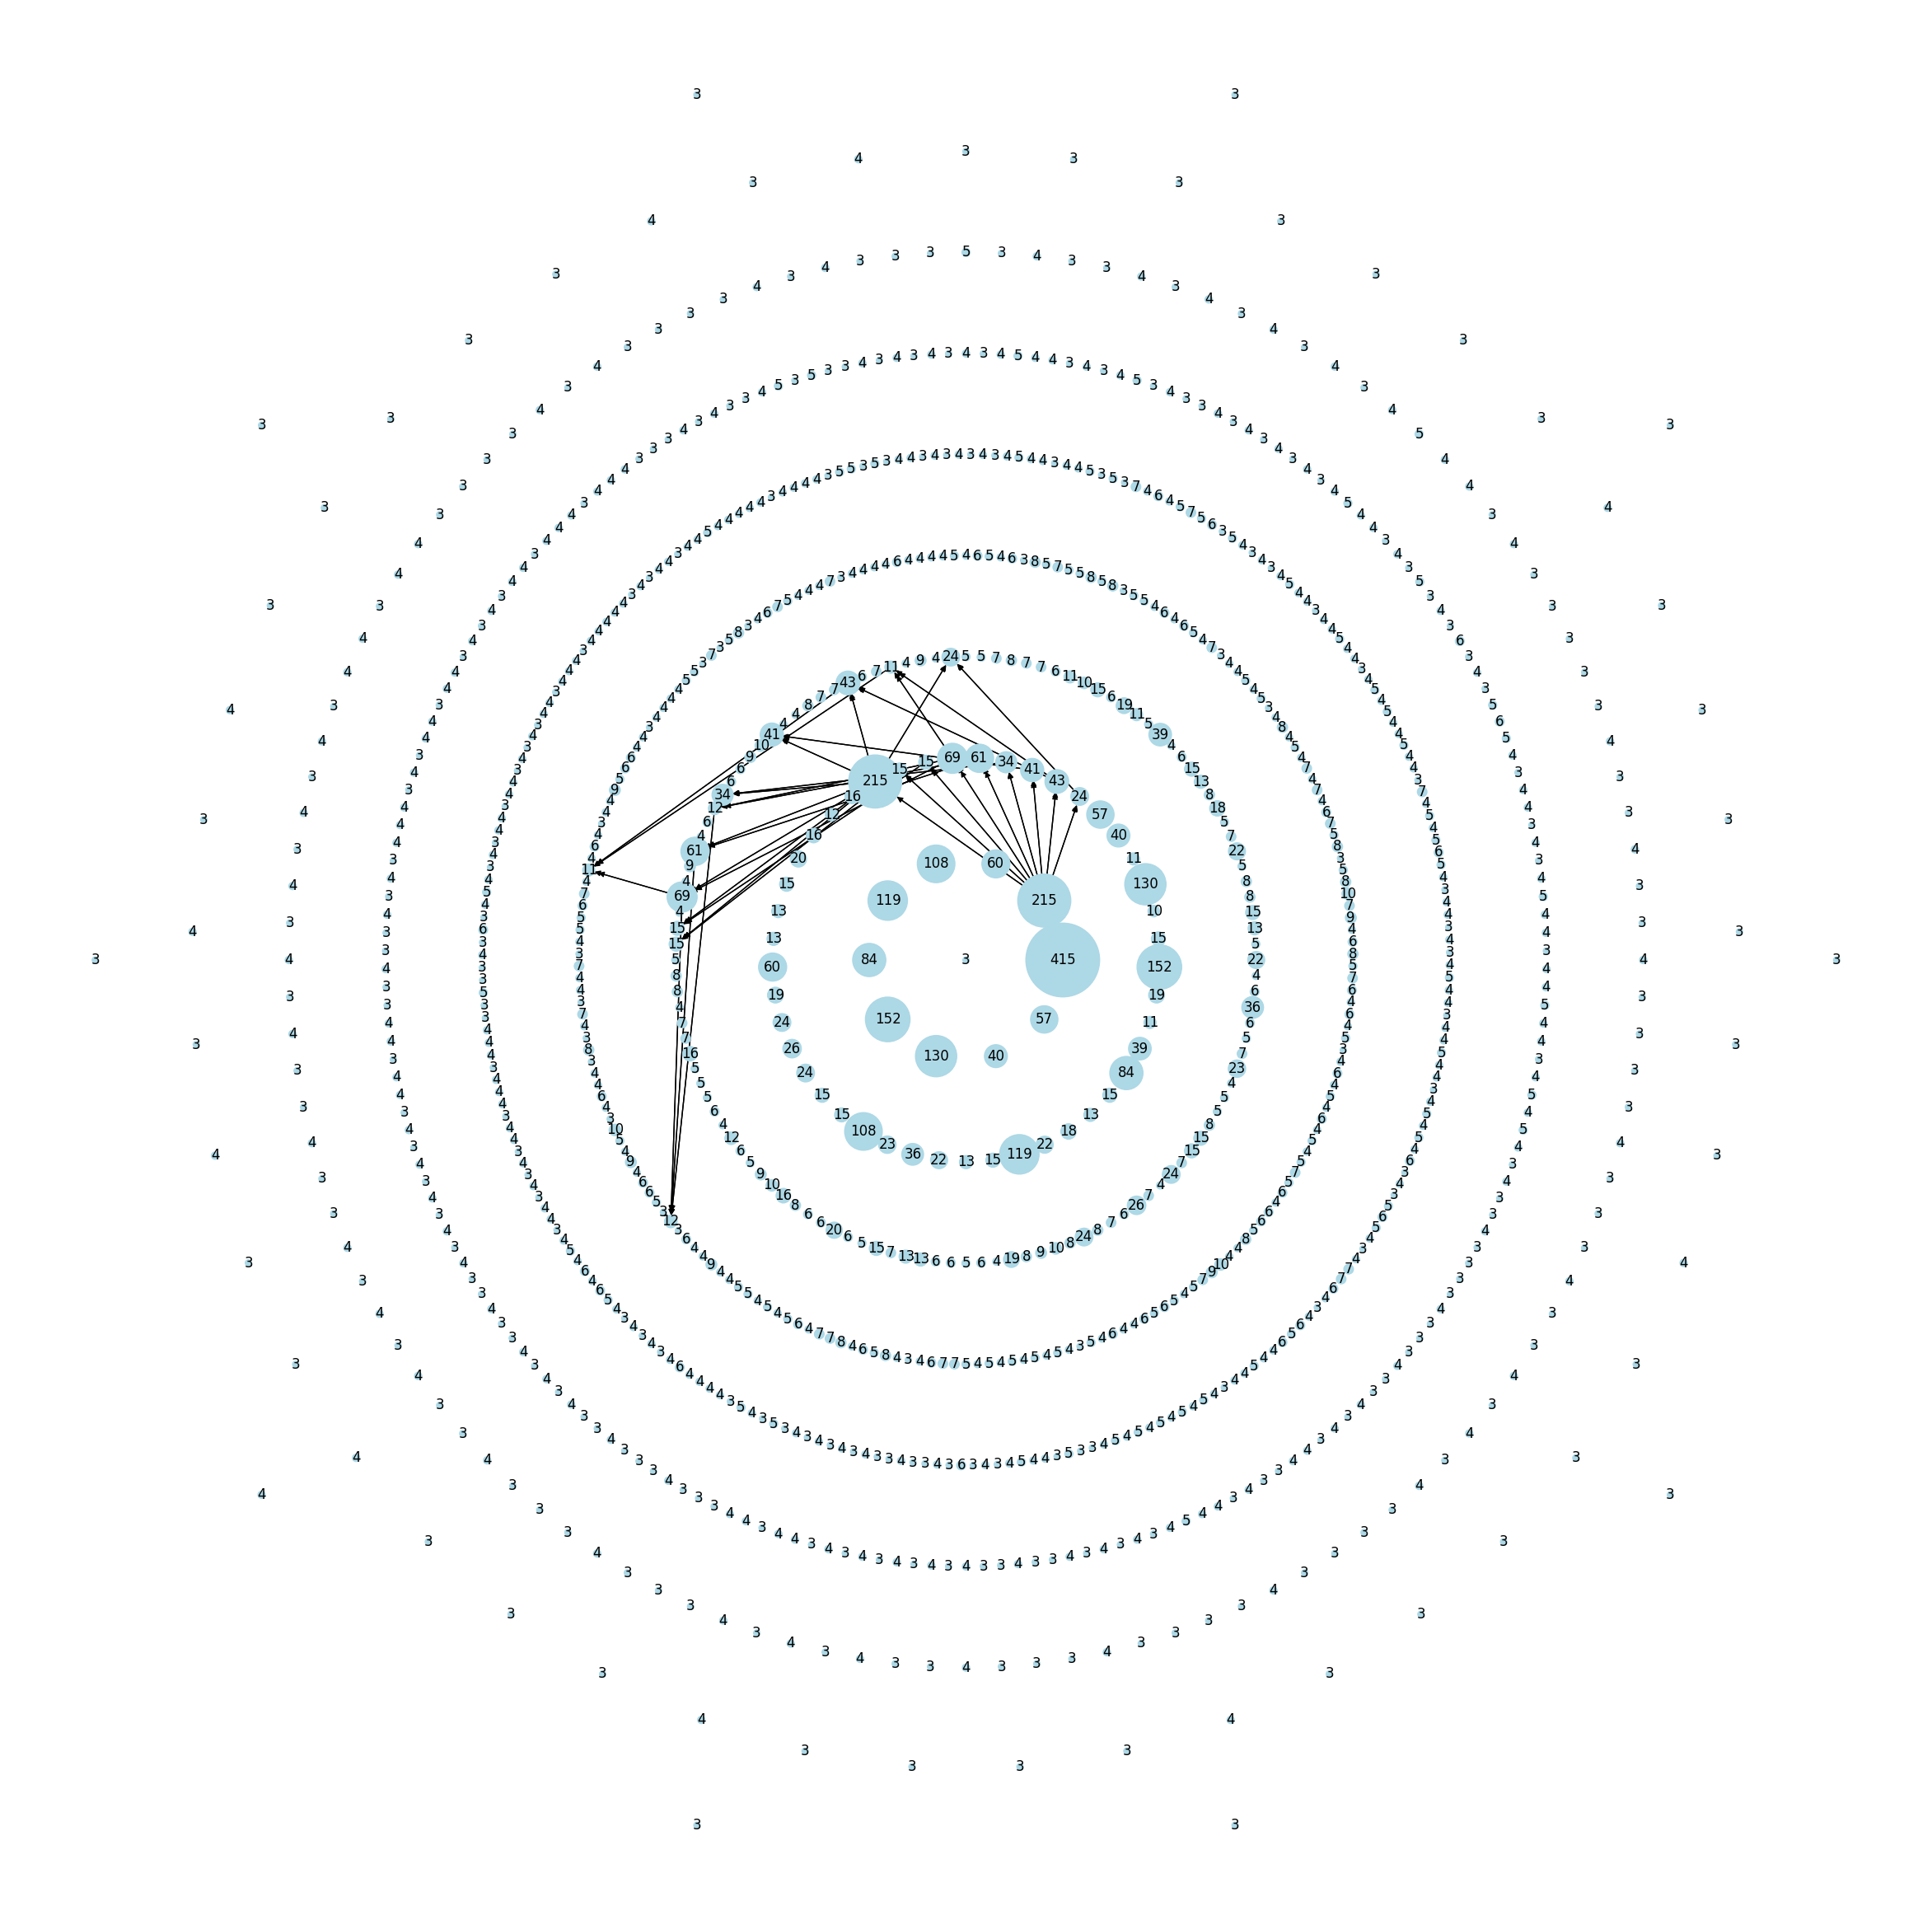

In [59]:
link_threshold = 10
edges_number_dict = {}
sub_graph_dict = {}
for target in RNA_list :
    
    graph, shells = create_cluster_map(presence_df)
    print("\nTarget : ", target)
    
    graph = link_nodes(
        graph,
        shells= shells,
        target=target,
        link_threshold=link_threshold
    )
    
    sub_graph_dict[target] = graph.copy()
    
    print("Number of edges : ", len(graph.edges))
    edges_number_dict[target] = len(graph.edges)
    
    if target == 'POLR2A' :
        fig = show_graph(graph, shells)
        fig.show()


Target :  POLR2A

Target :  POLR2I

Target :  POLR2J

Target :  POLR2F

Target :  POLR2H

Target :  POLR2E

Target :  POLR2B

Target :  POLR2K

Target :  POLR2L

Target :  POLR2C


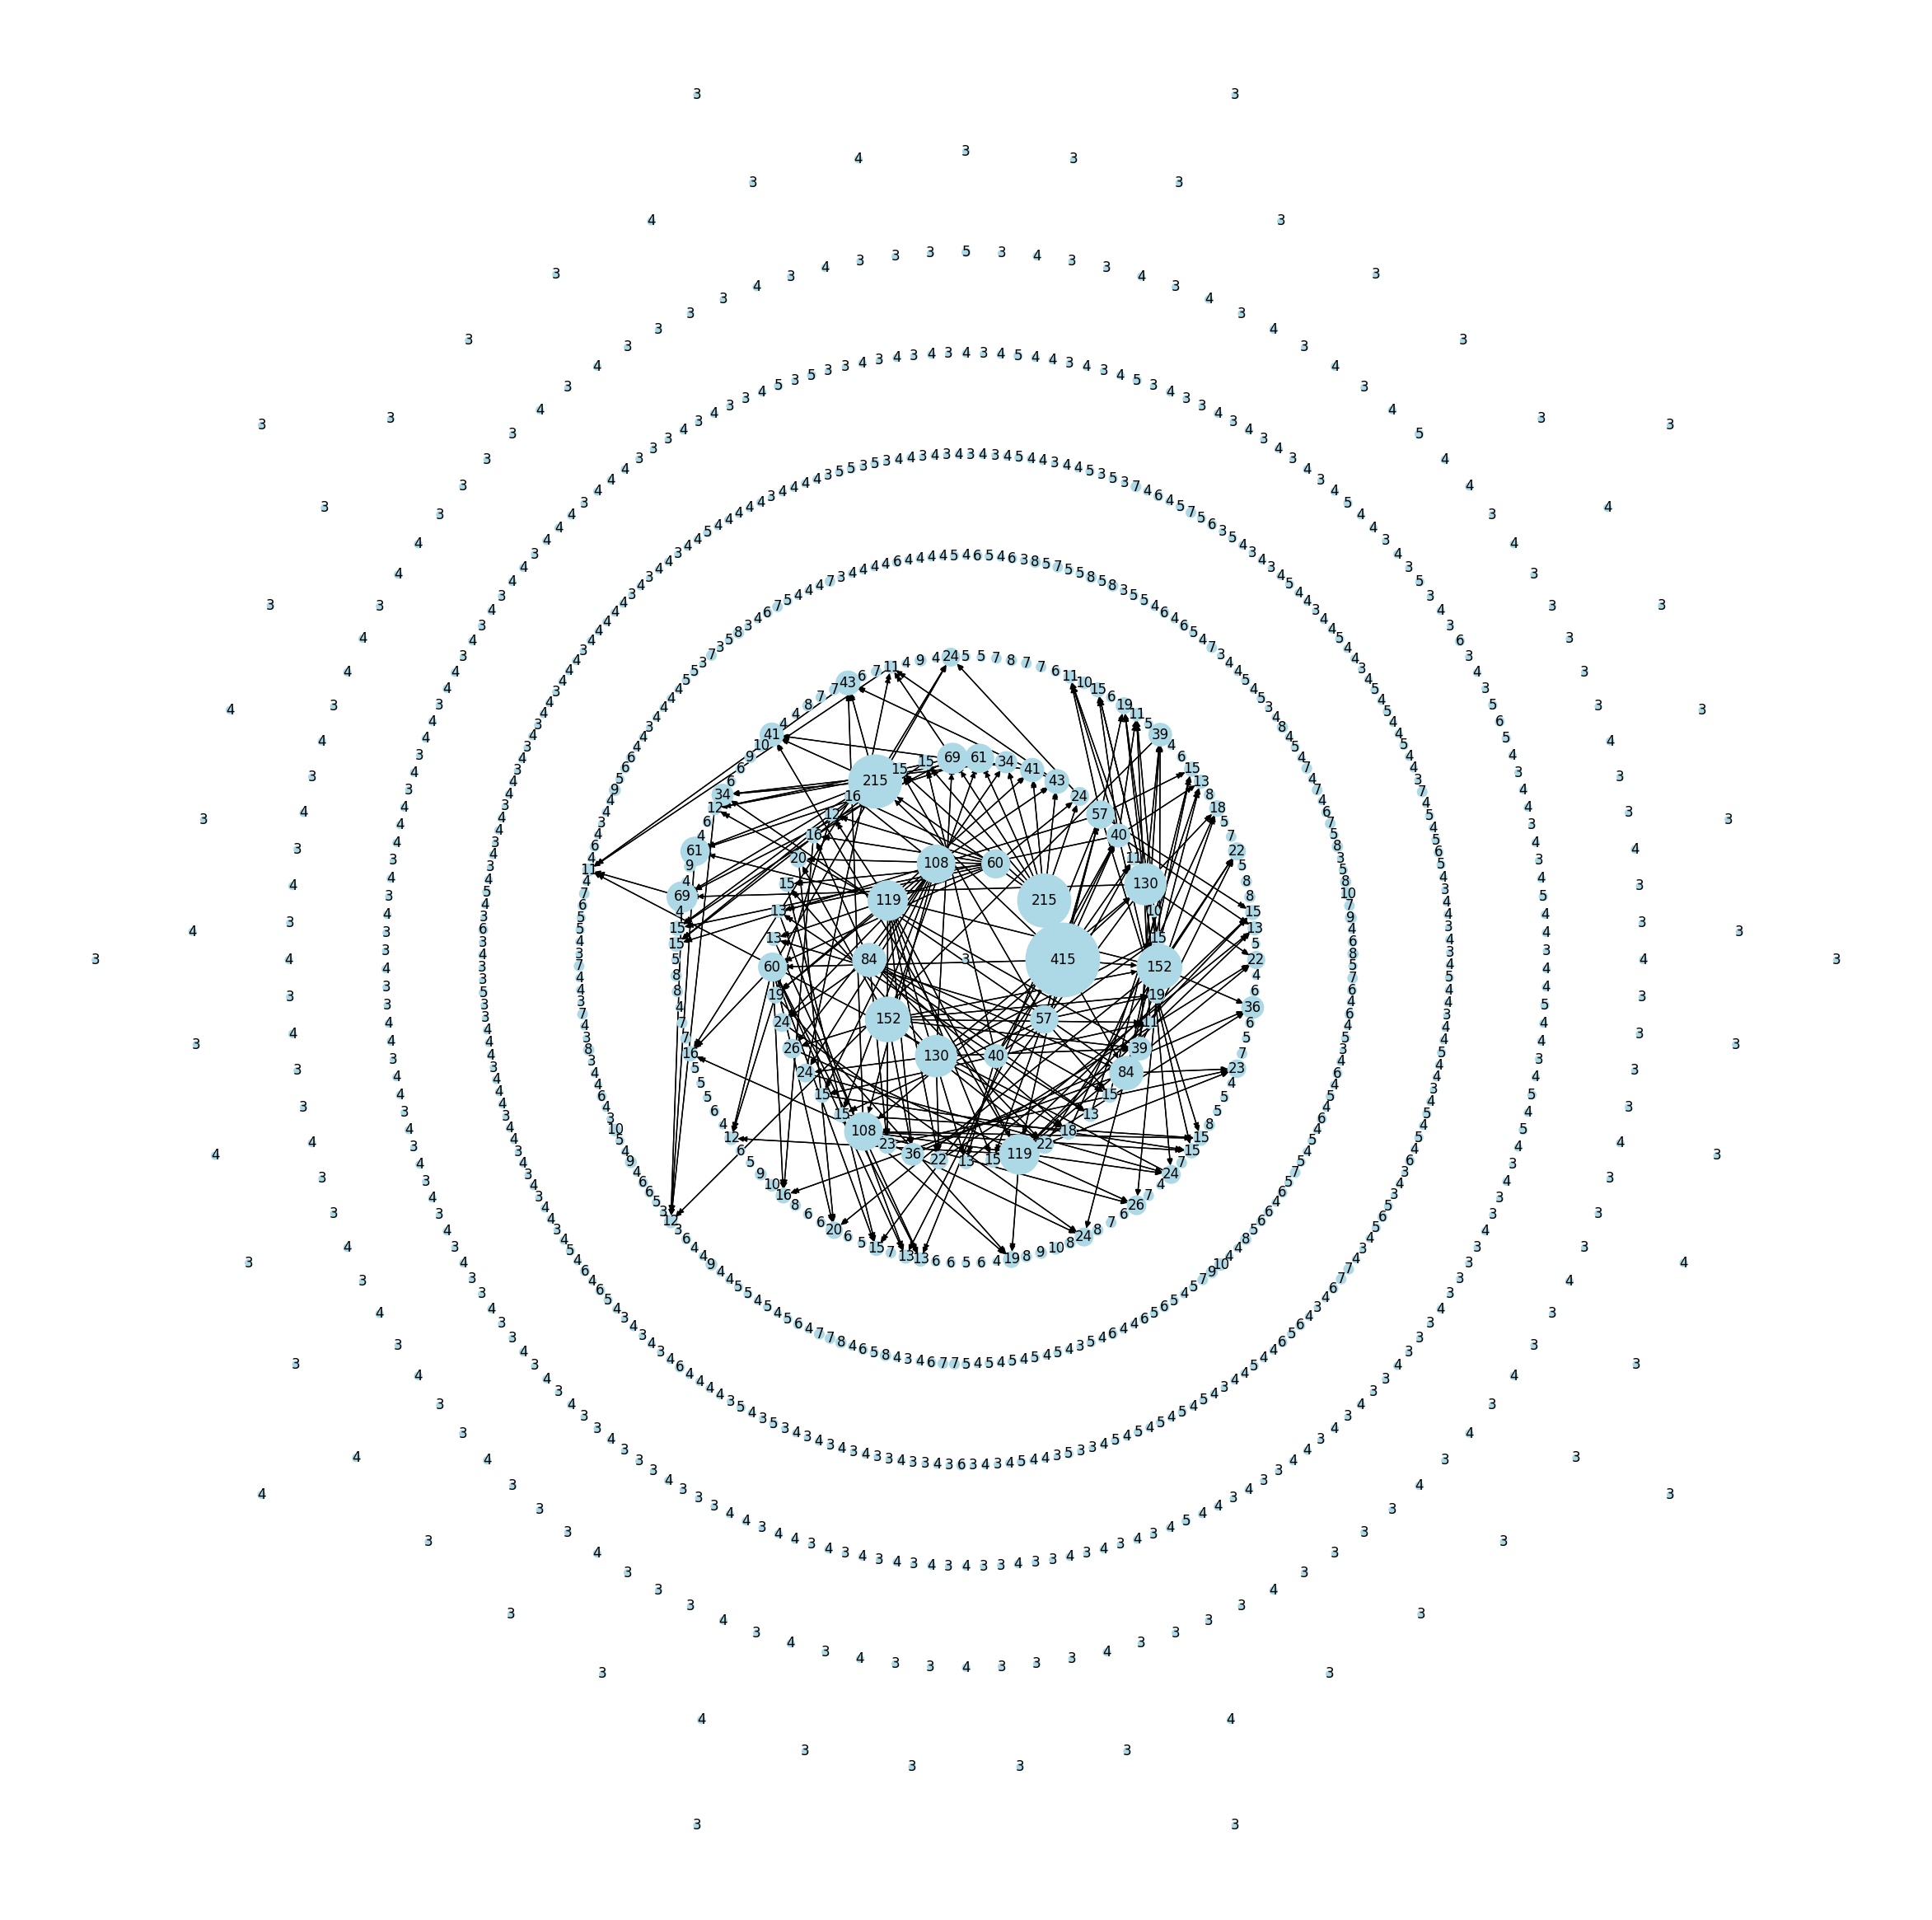

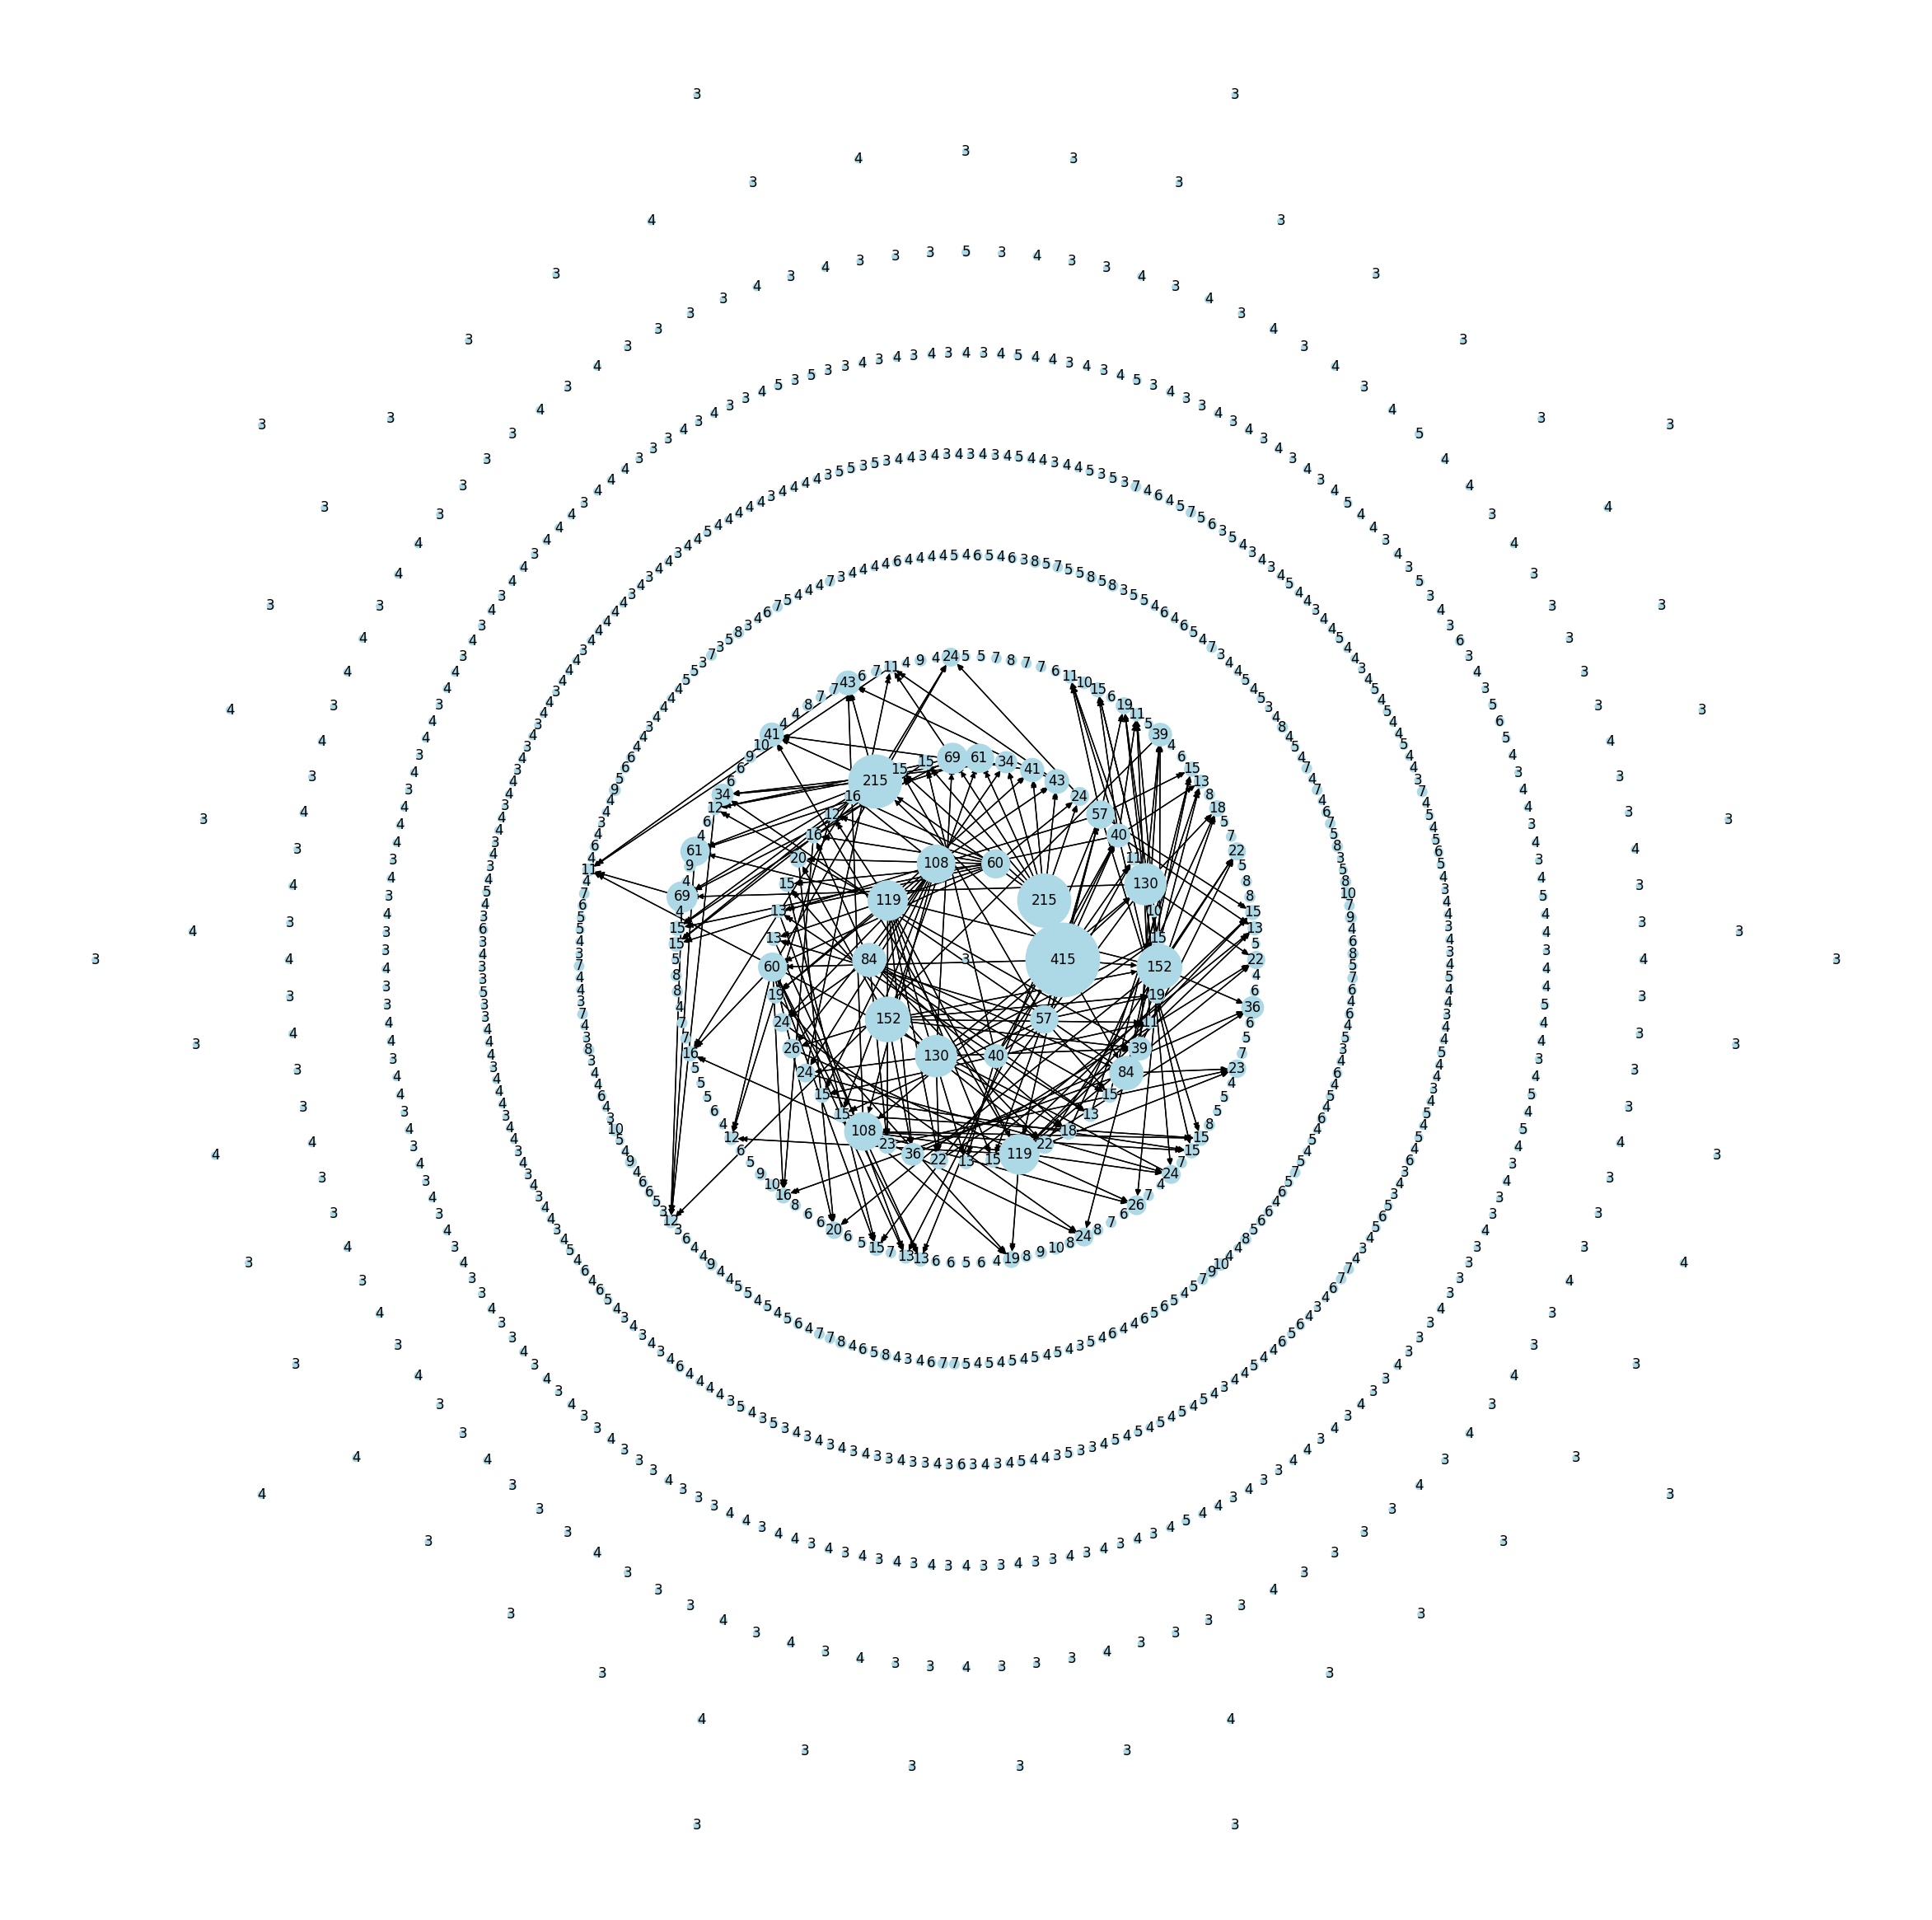

In [61]:
full_graph, shells = create_cluster_map(presence_df)
for target in RNA_list :
    
    print("\nTarget : ", target)
    
    full_graph = link_nodes(
        full_graph,
        shells= shells,
        target=target,
        link_threshold=link_threshold
    )
    
show_graph(full_graph, shells)


In [62]:
# for node in full_graph.nodes :

nodes = list(full_graph.nodes)
_, in_degree = zip(*full_graph.in_degree(nodes))
_, out_degree = zip(*full_graph.out_degree(nodes))
counts = [full_graph.nodes[node]['count'] for node in nodes]

graph_conectivity_frame = pd.DataFrame(
    index=nodes, 
    data= zip(in_degree,out_degree, counts), 
    columns= ['in_degree', 'out_degree', 'counts']
    )

graph_conectivity_frame = graph_conectivity_frame.reset_index(drop=False, names= 'index')
graph_conectivity_frame = graph_conectivity_frame.set_index('index', drop=False)
graph_conectivity_frame['dimension'] = graph_conectivity_frame['index'].apply(len)
graph_conectivity_frame = graph_conectivity_frame.drop(columns='index').sort_values(['in_degree','out_degree','dimension'], ascending=False)
graph_conectivity_frame


in_degree  out_degree  counts  dimension
index                                                                     
(POLR2A, POLR2J, POLR2B, POLR2C)          4           0      11          4
(POLR2A, POLR2E, POLR2B, POLR2C)          4           0      12          4
(POLR2A, POLR2B, POLR2C)                  3           2      69          3
(POLR2A, POLR2J, POLR2B)                  3           1      11          3
(POLR2A, POLR2J, POLR2C)                  3           1      43          3
...                                     ...         ...     ...        ...
(POLR2E, POLR2B, POLR2L)                  0           0       4          3
(POLR2E, POLR2K, POLR2L)                  0           0       5          3
(POLR2B, POLR2K, POLR2L)                  0           0       6          3
(POLR2B, POLR2L, POLR2C)                  0           0      10          3
(POLR2B, POLR2L)                          0           0      10          2

[1023 rows x 4 columns]

In [63]:
graph_conectivity_frame[graph_conectivity_frame['dimension'] > 2].sort_values(['counts','in_degree','out_degree'], ascending=False)

in_degree  out_degree  counts  dimension
index                                                                     
(POLR2A, POLR2B, POLR2C)                  3           2      69          3
(POLR2A, POLR2E, POLR2C)                  3           1      61          3
(POLR2A, POLR2J, POLR2C)                  3           1      43          3
(POLR2A, POLR2F, POLR2C)                  3           0      41          3
(POLR2E, POLR2B, POLR2C)                  3           1      39          3
...                                     ...         ...     ...        ...
(POLR2J, POLR2E, POLR2B, POLR2L)          0           0       3          4
(POLR2F, POLR2H, POLR2B, POLR2L)          0           0       3          4
(POLR2F, POLR2E, POLR2B, POLR2L)          0           0       3          4
(POLR2H, POLR2E, POLR2B, POLR2L)          0           0       3          4
(POLR2E, POLR2B, POLR2K, POLR2L)          0           0       3          4

[968 rows x 4 columns]

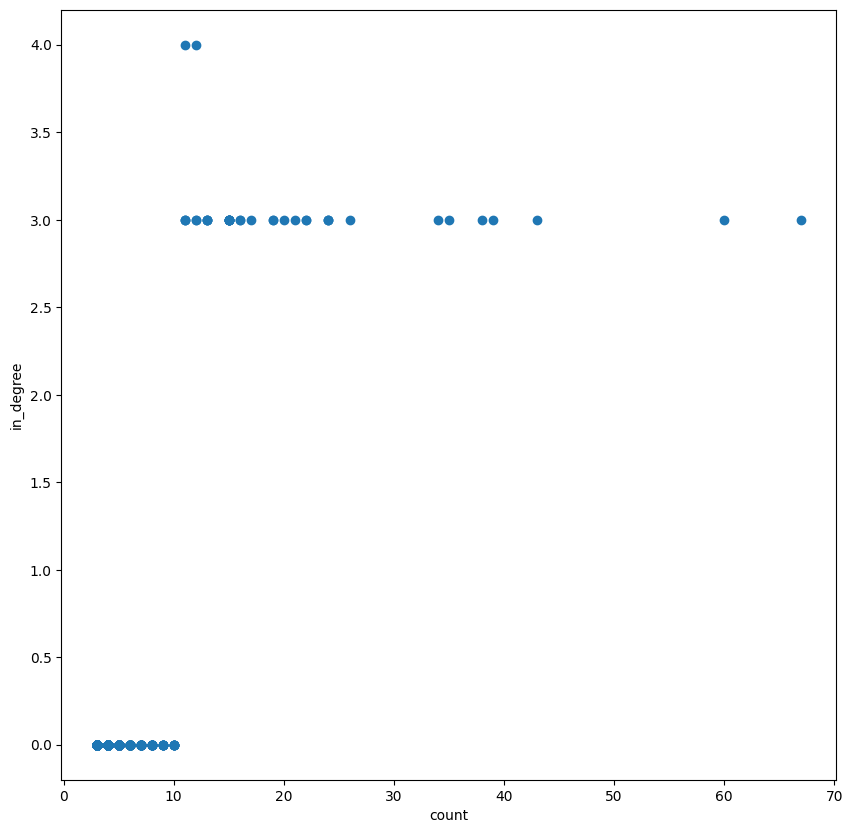

In [ ]:
data = graph_conectivity_frame.loc[graph_conectivity_frame['dimension'] > 2]

plt.figure(figsize=(10,10))
X = data['counts']
Y = data['in_degree']

plt.scatter(X,Y)

plt.xlabel('count')
plt.ylabel('in_degree')
# plt.xscale('log')

plt.show()